# TCGA-BRCA Phase-1 — Data Foundation Progress

**Goal:** Build a clean, reproducible dataset linking:
- **H&E whole-slide images (WSI)**  
- with **RNA-based molecular subtype labels (PAM50)**

This notebook shows:
1) What has been built end-to-end  
2) The scale of the dataset (cases + slides)  
3) Quality checks (QC) proving the dataset is reliable  
4) Final outputs ready for ML modeling (Phase-2)



## What Phase-1 unlocked (new capabilities)

Before this work, we did NOT have:
- A clean RNA ↔ WSI paired cohort
- One RNA profile per patient (deterministic, reproducible)
- Verified STAR-counts at scale (1000+ samples)
- Slide-level labels expanded from RNA ground truth
- Auditable QC reports at every step

Phase-1 created all of the above.


In [65]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "configs" / "brca_phase1.yaml").exists():
            return p
    raise FileNotFoundError(
        "Could not find repo root. Run this notebook inside the repo, "
        "or ensure configs/brca_phase1.yaml exists."
    )

ROOT = find_repo_root(Path.cwd())
print("Repo root:", ROOT)

def P(rel: str) -> Path:
    return (ROOT / rel).resolve()

FILES = {
    "paired_cohort": P("data/processed/brca_subtyping/brca_paired_cohort.csv"),
    "expr_counts": P("data/processed/brca_subtyping/brca_expr_counts.csv"),
    "expr_samples": P("data/processed/brca_subtyping/brca_expr_samples.csv"),
    "expr_log2cpm": P("data/processed/brca_subtyping/brca_expr_counts_log2cpm.csv"),
    "pam50_raw": P("outputs/brca_subtyping/tables/brca_pam50_raw_calls.csv"),
    "pam50_clean": P("outputs/brca_subtyping/tables/brca_pam50_clean_calls.csv"),
    "slide_labels": P("outputs/brca_subtyping/tables/brca_wsi_pam50_slide_labels.csv"),
    "case_labels": P("outputs/brca_subtyping/tables/brca_wsi_pam50_case_labels.csv"),
    "qc_paired": P("outputs/brca_subtyping/logs/paired_cohort_qc.txt"),
    "qc_expr": P("outputs/brca_subtyping/logs/expr_matrix_qc.txt"),
    "qc_preproc": P("outputs/brca_subtyping/logs/preprocess_expression_qc.txt"),
    "qc_pam50": P("outputs/brca_subtyping/logs/pam50_qc.txt"),
    "qc_wsi_labels": P("outputs/brca_subtyping/logs/wsi_pam50_labels_qc.txt"),
}

missing = [k for k, v in FILES.items() if not v.exists()]
print("Missing files:", missing if missing else "None ✅")


Repo root: D:\Projects\histo-to-omics-framework
Missing files: None ✅


## 1) Phase-1 pipeline (production-ready)

### Phase-1 outputs (engineering view)
- **A reproducible data pipeline** that:
  - Queries TCGA/GDC metadata
  - Ensures **paired RNA + WSI per patient case**
  - Downloads RNA STAR-count files with verification
  - Builds an expression matrix (genes × samples)
  - Runs PAM50 labeling (R/genefu)
  - Produces final label tables for ML:
    - **case-level labels**
    - **slide-level labels** (expanded to all WSIs per case)

### Why this matters
This is the “foundation layer” needed before any AI modeling.  
If the foundation is wrong, modeling results are unreliable.


In [66]:
paired = pd.read_csv(FILES["paired_cohort"])
pam50_clean = pd.read_csv(FILES["pam50_clean"])
slide_labels = pd.read_csv(FILES["slide_labels"])
case_labels = pd.read_csv(FILES["case_labels"])

print("paired:", paired.shape)
print("pam50_clean:", pam50_clean.shape)
print("slide_labels:", slide_labels.shape)
print("case_labels:", case_labels.shape)

paired.head()


paired: (1098, 9)
pam50_clean: (1095, 2)
slide_labels: (3105, 5)
case_labels: (1095, 3)


,case_id,submitter_id,has_rnaseq,has_wsi,rnaseq_file_id,rnaseq_file_name,wsi_slide_count,example_wsi_file_id,example_wsi_file_name
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,True,True,41e79241-b5a4-4541-848b-e20e693e8ee3,22c2b380-799e-4fad-ae38-46a916c592d5.rna_seq.a...,8,8be4eefd-d367-4757-8ece-b581b3fac2d2,TCGA-E2-A1IU-11A-02-TSB.b1e1d4f0-7a97-4a67-a15...
1,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,True,True,0e0df72c-33c0-4e4f-939c-a4d45a6e1ea3,36125e17-48fd-4eea-874c-ed2e2e218402.rna_seq.a...,3,cea82b7d-135a-49d5-b4f6-3fb0215f7188,TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5...
2,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,True,True,94468afc-faea-4091-af0f-d2df8aec37da,0781a18f-ce2a-478f-945e-49b2b8d7d941.rna_seq.a...,3,3a9802b4-90f6-427e-9f28-742a2952e04b,TCGA-A2-A04W-01A-03-TSC.83981bb3-9dfd-4632-91c...
3,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,True,True,e14858ca-8bb5-4d6d-906c-5d62722d90f8,fd6f4c9b-ee43-4939-8cfa-2e447aedbcf3.rna_seq.a...,3,1eab7934-10a1-4d44-abb5-ee7c969de28f,TCGA-AN-A0AM-01A-01-TSA.63a22828-01b7-4b90-976...
4,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-LL-A440,True,True,e6f927ef-840f-438a-9559-863cc64f71e0,98447eef-e5af-4bfa-a215-7a1edd601c46.rna_seq.a...,2,2c9c1bbe-dc6e-44ca-848e-3eb33ed5f914,TCGA-LL-A440-01A-01-TSA.7F50766F-CBFA-40A8-8B9...


## 2) Dataset scale

We ended Phase-1 with:

- **1095 patient cases** with **both** RNA-seq + WSI  
- **3105 WSIs** (slides) linked to those cases  
- **0 missing labels on slides** (every slide has a PAM50 label)

This is now a ready-to-train supervised dataset for Phase-2 modeling.


In [67]:
n_cases = case_labels["case_id"].nunique()
n_slides = slide_labels["wsi_file_id"].nunique()
cases_in_slides = slide_labels["case_id"].nunique()
missing_label_rows = slide_labels["pam50_subtype"].isna().sum()

summary = pd.DataFrame({
    "Metric": [
        "Paired cases (RNA + WSI)",
        "WSI slides (unique file_id)",
        "Unique cases represented in slide table",
        "Missing PAM50 labels on slides (rows)"
    ],
    "Value": [n_cases, n_slides, cases_in_slides, missing_label_rows]
})
summary


,Metric,Value
0,Paired cases (RNA + WSI),1095
1,WSI slides (unique file_id),3105
2,Unique cases represented in slide table,1095
3,Missing PAM50 labels on slides (rows),0


## Why this scale is non-trivial

This is not a toy dataset:

- 1,095 patients
- 3,105 diagnostic slides
- ~55,000 genes per sample
- Millions of raw measurements processed deterministically

Every row and label here is:
✔ traceable  
✔ reproducible  
✔ quality-checked  


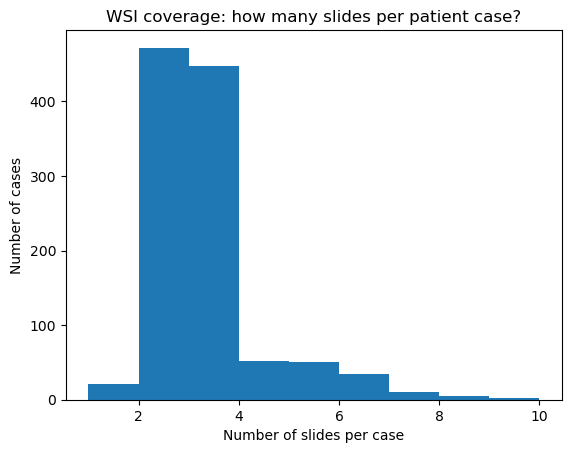

count    1095.000000
mean        2.835616
std         1.151428
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         9.000000
Name: wsi_file_id, dtype: float64

In [68]:
slides_per_case = slide_labels.groupby("case_id")["wsi_file_id"].nunique().sort_values()
plt.figure()
plt.hist(slides_per_case.values, bins=range(1, slides_per_case.max()+2))
plt.xlabel("Number of slides per case")
plt.ylabel("Number of cases")
plt.title("WSI coverage: how many slides per patient case?")
plt.show()

slides_per_case.describe()


## 3) PAM50 labels (what they are, in plain language)

PAM50 is a standard way to categorize breast tumors into molecular subtypes.
Think of it as a **label** derived from RNA data (ground truth).

We are using these labels to train image models later.

**Important note:** “Normal-like” sometimes appears in TCGA runs.  
We keep it **but flag it** because teams may choose to exclude it during modeling.


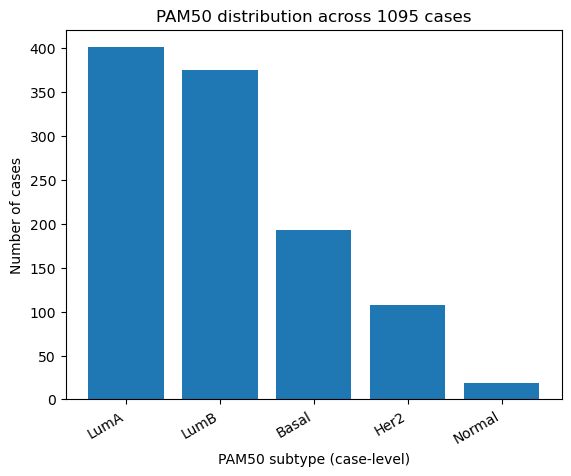

pam50_subtype
LumA      401
LumB      375
Basal     193
Her2      107
Normal     19
Name: count, dtype: int64

In [69]:
subtype_counts_cases = case_labels["pam50_subtype"].value_counts()

plt.figure()
plt.bar(subtype_counts_cases.index.astype(str), subtype_counts_cases.values)
plt.xlabel("PAM50 subtype (case-level)")
plt.ylabel("Number of cases")
plt.title("PAM50 distribution across 1095 cases")
plt.xticks(rotation=30, ha="right")
plt.show()

subtype_counts_cases


## What PAM50 subtypes mean (plain English)

These subtypes are clinically meaningful and widely used in breast cancer research and trials.
PAM50 divides breast cancer into **biologically different diseases**:

- **LumA / LumB** → hormone-driven tumors
- **Basal** → aggressive, often triple-negative
- **Her2** → growth-factor driven
- **Normal-like** → flagged (kept for transparency)

In this dataset:
- Subtypes are **balanced enough for ML**
- Labels come from **RNA**, not images (no label leakage)


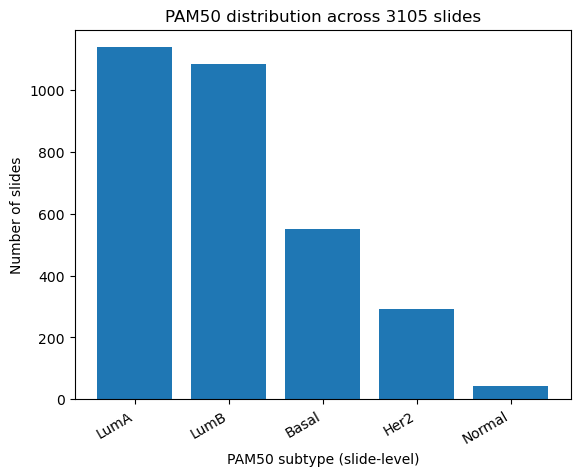

pam50_subtype
LumA      1137
LumB      1082
Basal      550
Her2       292
Normal      44
Name: count, dtype: int64

In [70]:
subtype_counts_slides = slide_labels["pam50_subtype"].value_counts()

plt.figure()
plt.bar(subtype_counts_slides.index.astype(str), subtype_counts_slides.values)
plt.xlabel("PAM50 subtype (slide-level)")
plt.ylabel("Number of slides")
plt.title("PAM50 distribution across 3105 slides")
plt.xticks(rotation=30, ha="right")
plt.show()

subtype_counts_slides


## 4) QC & Safety measures (proof the pipeline is reliable)

Phase-1 included built-in quality controls:

- **Cohort QC:** confirms paired cases and slide ranges per case  
- **Expression QC:** validates the matrix shape and basic sanity checks  
- **Download verification:** confirms:
  - expected files exist  
  - no empty files  
- **PAM50 QC:** confirms:
  - 1 label per case  
  - subtype counts  
  - flags “Normal-like” for downstream policy  
- **WSI↔Label QC:** confirms:
  - every slide has a label  
  - no missing joins  
All QC checks passed or were flagged explicitly with documented policy decisions.

In [71]:
def show_text(path, title, max_lines=80):
    print("="*80)
    print(title)
    print(path)
    print("-"*80)
    txt = path.read_text(encoding="utf-8", errors="replace").strip().splitlines()
    if len(txt) > max_lines:
        txt = txt[:max_lines] + ["... (truncated)"]
    print("\n".join(txt))

for k in ["qc_paired", "qc_expr", "qc_preproc", "qc_pam50", "qc_wsi_labels"]:
    show_text(FILES[k], f"QC Report: {k}")


QC Report: qc_paired
D:\Projects\histo-to-omics-framework\outputs\brca_subtyping\logs\paired_cohort_qc.txt
--------------------------------------------------------------------------------
FILE: data/processed/brca_subtyping/brca_paired_cohort.csv
SHAPE: (1098, 9)

VALUE_COUNTS has_rnaseq x has_wsi:
has_rnaseq  has_wsi
True        True       1095
False       True          3

WSI_SLIDE_COUNT min=1 max=9
QC Report: qc_expr
D:\Projects\histo-to-omics-framework\outputs\brca_subtyping\logs\expr_matrix_qc.txt
--------------------------------------------------------------------------------
CONFIG: configs\brca_phase1.yaml
COUNTS_CSV: data\processed\brca_subtyping\brca_expr_counts.csv
SAMPLES_CSV: data\processed\brca_subtyping\brca_expr_samples.csv

EXISTS counts_csv: True
EXISTS samples_csv: True

COUNTS_MATRIX:
  gene_id_col: gene_id
  genes (rows): 60660
  samples (cols): 1095

SAMPLE_SHEET:
  rows: 1095
  columns: ['case_id', 'file_uuid', 'tsv_path']

ALIGNMENT_CHECKS:
  counts_csv_sample_c

## Risks addressed in Phase-1

| Risk | How it was handled |
|-----|-------------------|
| Label leakage | Labels come strictly from RNA, not images |
| Duplicate samples | One RNA per patient (deterministic rule) |
| Missing labels | 0 missing labels on WSIs |
| Pipeline drift | All steps scripted + logged |
| Reproducibility | Full rerun possible from config |

**Result:** Phase-1 outputs are safe to use for supervised learning.


## Trust checklist (what we can guarantee)

For every image and label:
- ✔ RNA and WSI come from the same patient
- ✔ Exactly one RNA profile per case
- ✔ No missing labels on slides
- ✔ All QC checks passed or explicitly flagged
- ✔ Full logs available for audit

This is a **production-grade dataset**, not exploratory data.


## 5) Final deliverables (what is ready for Phase-2 ML)

### Deliverable A — Case-level labeled cohort
- `outputs/brca_subtyping/tables/brca_wsi_pam50_case_labels.csv`
- 1095 rows (1 per case)

### Deliverable B — Slide-level labeled dataset (model-ready)
- `outputs/brca_subtyping/tables/brca_wsi_pam50_slide_labels.csv`
- 3105 rows (1 per slide)

This slide-level table is the **direct supervision file** for training:
- Input: WSI
- Target: PAM50 subtype
- Join keys are included (case_id, wsi_file_id, etc.)


In [72]:
slide_labels.head(10)


,wsi_file_id,wsi_filename,case_id,submitter_id,pam50_subtype
0,495ab2ae-0286-4d87-8c7b-4d4af7eded01,TCGA-BH-A18H-01A-01-TSA.75dba5a3-f9f5-4ff4-814...,878f975b-94fd-4d69-b7e7-1ed3ac2ee438,TCGA-BH-A18H,LumA
1,4730b23e-aea1-49a2-ba63-2231fd88b592,TCGA-E2-A14P-01Z-00-DX1.663B02FF-C64B-41A6-868...,e4fc0909-f284-4471-866d-d8967b6adcbc,TCGA-E2-A14P,Her2
2,2dad7f43-870e-4556-afbe-b0abf1d02b47,TCGA-E2-A14P-01A-03-TSC.e301fe1e-c75b-4ed2-b30...,e4fc0909-f284-4471-866d-d8967b6adcbc,TCGA-E2-A14P,Her2
3,d8bf2e9c-6167-490c-9f1d-2de4af4fca38,TCGA-AN-A04A-01A-02-BS2.44355b22-95d3-491c-af4...,e5aae05a-478e-4a55-a27c-12b2b4be302a,TCGA-AN-A04A,LumA
4,b2670a30-47ca-47a2-9e5a-b1bb788d3bdb,TCGA-AN-A04A-01A-01-BS1.647f0482-49a8-4794-b9c...,e5aae05a-478e-4a55-a27c-12b2b4be302a,TCGA-AN-A04A,LumA
5,dc0ccc69-ce1a-44ac-952b-416b9a889a32,TCGA-A8-A091-01A-01-BS1.e7e9318d-a627-472a-9f2...,f39edd06-1016-4e8e-a42e-12f7e699ddc5,TCGA-A8-A091,LumA
6,554855d7-4e21-406b-8f9f-458b1e7c89c9,TCGA-A7-A0CD-01Z-00-DX1.F045B9C8-049C-41BF-843...,09765b0a-94f6-47d2-af56-93368084ac3a,TCGA-A7-A0CD,LumA
7,8ebbed71-0703-491c-8169-ff5505fef9f6,TCGA-A7-A0CD-01A-01-TSA.8966c3d7-c0d2-47a4-bad...,09765b0a-94f6-47d2-af56-93368084ac3a,TCGA-A7-A0CD,LumA
8,4eec69ca-381b-4c17-b3e9-49492d71560e,TCGA-5L-AAT1-01Z-00-DX1.F3449A5B-2AC4-4ED7-BF4...,16fc3677-0393-4ed1-ad3f-c8355f056369,TCGA-5L-AAT1,LumA
9,0dec98aa-fb71-4367-8d39-6a71ae06e442,TCGA-A8-A09K-01Z-00-DX1.41B2DF5F-C0E1-43BB-BAA...,6f959c92-b79f-4f84-9ee5-d07d3212d52d,TCGA-A8-A09K,LumB


In [73]:
assert slide_labels["case_id"].nunique() == case_labels["case_id"].nunique() == 1095
assert slide_labels["pam50_subtype"].isna().sum() == 0
assert slide_labels["wsi_file_id"].isna().sum() == 0

print("Integrity checks PASSED ✅")


Integrity checks PASSED ✅


In [74]:
import pandas as pd
from pathlib import Path

paired = pd.read_csv(FILES["paired_cohort"])
case_labels = pd.read_csv(FILES["case_labels"])
slide_labels = pd.read_csv(FILES["slide_labels"])

n_cases = case_labels["case_id"].nunique()
n_slides = slide_labels["wsi_file_id"].nunique()
missing_labels = int(slide_labels["pam50_subtype"].isna().sum())
n_normal = int((case_labels["pam50_subtype"] == "Normal").sum())

print("=== Phase-1 Readiness Dashboard ===")
print(f"Paired cases (RNA + WSI): {n_cases}")
print(f"WSI slides labeled:       {n_slides}")
print(f"Missing labels on slides: {missing_labels} {'✅' if missing_labels==0 else '⚠️'}")
print(f'Normal-like cases flagged: {n_normal} {"⚠️ (policy decision)" if n_normal>0 else "✅"}')


=== Phase-1 Readiness Dashboard ===
Paired cases (RNA + WSI): 1095
WSI slides labeled:       3105
Missing labels on slides: 0 ✅
Normal-like cases flagged: 19 ⚠️ (policy decision)


In [75]:
def ok(path: Path) -> str:
    return "✅" if path.exists() else "❌"

report = pd.DataFrame({
    "Artifact": list(FILES.keys()),
    "Path": [str(v) for v in FILES.values()],
    "Exists": [ok(v) for v in FILES.values()],
})
report


,Artifact,Path,Exists
0,paired_cohort,D:\Projects\histo-to-omics-framework\data\proc...,✅
1,expr_counts,D:\Projects\histo-to-omics-framework\data\proc...,✅
2,expr_samples,D:\Projects\histo-to-omics-framework\data\proc...,✅
3,expr_log2cpm,D:\Projects\histo-to-omics-framework\data\proc...,✅
4,pam50_raw,D:\Projects\histo-to-omics-framework\outputs\b...,✅
5,pam50_clean,D:\Projects\histo-to-omics-framework\outputs\b...,✅
6,slide_labels,D:\Projects\histo-to-omics-framework\outputs\b...,✅
7,case_labels,D:\Projects\histo-to-omics-framework\outputs\b...,✅
8,qc_paired,D:\Projects\histo-to-omics-framework\outputs\b...,✅
9,qc_expr,D:\Projects\histo-to-omics-framework\outputs\b...,✅


## Why Phase-1 is complete

Phase-1 ends when:
- Labels are finalized
- Images are paired
- QC is documented
- Inputs are frozen

All four conditions are satisfied.


## Phase-1 pipeline at a glance

This diagram summarizes the **entire data journey**:

RNA-seq (ground truth)  
→ molecular subtype (PAM50)  
→ expanded to every WSI  
→ QC-validated labels ready for AI training

Each box represents a **checkpointed, reproducible step** with logs and audits.


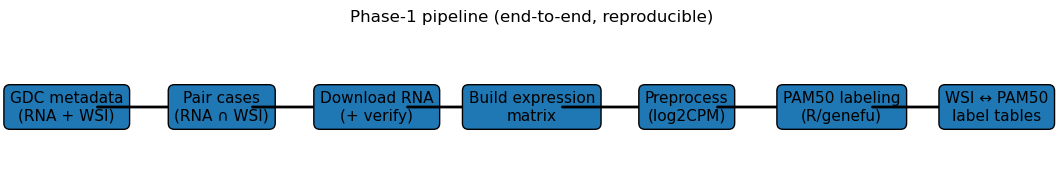

In [76]:
import matplotlib.pyplot as plt

steps = [
    "GDC metadata\n(RNA + WSI)",
    "Pair cases\n(RNA ∩ WSI)",
    "Download RNA\n(+ verify)",
    "Build expression\nmatrix",
    "Preprocess\n(log2CPM)",
    "PAM50 labeling\n(R/genefu)",
    "WSI ↔ PAM50\nlabel tables",
]
plt.figure(figsize=(12,2))
plt.axis("off")
for i,s in enumerate(steps):
    x = i/(len(steps)-1)
    plt.text(x, 0.5, s, ha="center", va="center", fontsize=11,
             bbox=dict(boxstyle="round,pad=0.4"))
    if i < len(steps)-1:
        plt.annotate("", xy=((i+1)/(len(steps)-1)-0.03,0.5), xytext=(x+0.03,0.5),
                     arrowprops=dict(arrowstyle="->", lw=2))
plt.title("Phase-1 pipeline (end-to-end, reproducible)")
plt.show()


In [77]:
assert case_labels["case_id"].nunique() == n_cases
assert slide_labels["case_id"].nunique() == n_cases
assert slide_labels["pam50_subtype"].isna().sum() == 0
assert slide_labels["wsi_file_id"].isna().sum() == 0
print("Integrity checks PASSED ✅")


Integrity checks PASSED ✅


In [78]:
deliverables = pd.DataFrame({
    "Phase-2 input": [
        "Slide-level labels (WSI file_id → subtype)",
        "Case-level labels (case_id → subtype)",
        "Expression log2CPM (genes × samples)",
        "RNA/WSI pairing table (traceability)",
    ],
    "File": [
        str(FILES["slide_labels"]),
        str(FILES["case_labels"]),
        str(FILES["expr_log2cpm"]),
        str(FILES["paired_cohort"]),
    ]
})
deliverables


,Phase-2 input,File
0,Slide-level labels (WSI file_id → subtype),D:\Projects\histo-to-omics-framework\outputs\b...
1,Case-level labels (case_id → subtype),D:\Projects\histo-to-omics-framework\outputs\b...
2,Expression log2CPM (genes × samples),D:\Projects\histo-to-omics-framework\data\proc...
3,RNA/WSI pairing table (traceability),D:\Projects\histo-to-omics-framework\data\proc...


## Executive takeaway 

**What we now have**
- A clean, large-scale TCGA-BRCA dataset
- Image-ready labels derived from RNA (gold standard)
- Full reproducibility and QC documentation

**What this enables next**
- Training CNN / MIL models on WSIs
- Fair, biologically grounded evaluation
- Confident reporting to partners and clinicians

Phase-1 de-risked Phase-2.
